# Import Libraries and Set Seed

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#Generate Sine-Wave Training Data


In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])

train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

print("First 5 (x, y) samples:")
for i in range(5):
    print(f"{train_set[i][0].tolist()}")


First 5 (x, y) samples:
[5.543461322784424, -0.6740840673446655]
[5.749139785766602, -0.509019672870636]
[2.405604124069214, 0.6713201403617859]
[6.027495384216309, -0.2529129683971405]
[2.453258514404297, 0.635251522064209]


# Visualize Sine-Wave Training Data

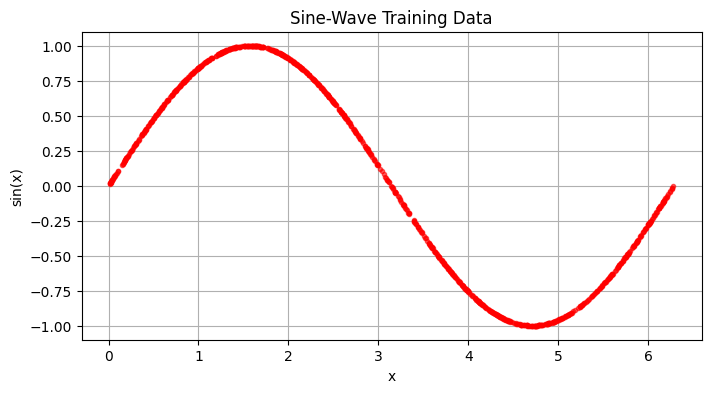

In [4]:
x_vals = train_data[:, 0]
y_vals = train_data[:, 1]

plt.figure(figsize=(8, 4))
plt.plot(x_vals, y_vals, ".", alpha=0.6, color='red')
plt.title("Sine-Wave Training Data")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.grid(True)
plt.show()

# Create DataLoader


In [5]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
print(f"Total number of batches: {len(train_loader)}")

Total number of batches: 32


#Define Discriminator Model


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)

print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


# Define Generator Model


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator().to(device)

print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


#Set Hyperparameters and Loss Function


In [8]:
num_epochs = 2000
lr = 0.001
loss_function = nn.BCELoss()
loss_function = loss_function.to(device)
print("Hyperparameters and loss function set.")


Hyperparameters and loss function set.


#Define Optimizers


In [11]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

print("Optimizers initialized.")


Optimizers initialized.


#Train GAN on Sine-Wave Data


In [12]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device)


        real_labels = torch.ones((batch_size, 1)).to(device)

        noise = torch.randn((batch_size, 2)).to(device)
        fake_samples = generator(noise)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        all_samples = torch.cat((real_samples, fake_samples), dim=0)
        all_labels = torch.cat((real_labels, fake_labels), dim=0)

        discriminator.zero_grad()

        output = discriminator(all_samples)
        loss_discriminator = loss_function(output, all_labels)

        loss_discriminator.backward()
        optimizer_discriminator.step()

        noise = torch.randn((batch_size, 2)).to(device)
        generator.zero_grad()

        generated_samples = generator(noise)
        output_discriminator = discriminator(generated_samples)

        loss_generator = loss_function(output_discriminator, real_labels)
        loss_generator.backward()
        optimizer_generator.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator.item():.4f} | Loss G: {loss_generator.item():.4f}")


Epoch 0 | Loss D: 0.0879 | Loss G: 2.6136
Epoch 200 | Loss D: 0.6928 | Loss G: 0.6268
Epoch 400 | Loss D: 0.6943 | Loss G: 0.7233
Epoch 600 | Loss D: 0.6337 | Loss G: 0.7822
Epoch 800 | Loss D: 0.6533 | Loss G: 0.8256
Epoch 1000 | Loss D: 0.6897 | Loss G: 0.8784
Epoch 1200 | Loss D: 0.6920 | Loss G: 0.6764
Epoch 1400 | Loss D: 0.6419 | Loss G: 0.8413
Epoch 1600 | Loss D: 0.6422 | Loss G: 0.7314
Epoch 1800 | Loss D: 0.6930 | Loss G: 0.7010


# Step 10: Generate and Visualize Samples After Training


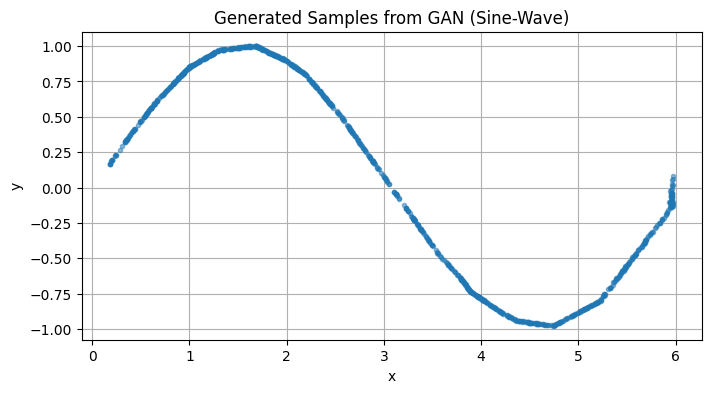

In [13]:
latent_samples = torch.randn(1000, 2).to(device)
generated_data = generator(latent_samples).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(generated_data[:, 0], generated_data[:, 1], ".", alpha=0.5)
plt.title("Generated Samples from GAN (Sine-Wave)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


# Section 2 Generate Mixture of Gaussians Training Data


In [14]:
from sklearn.datasets import make_blobs

n_samples = 1024
centers = [(-2, -2), (-2, 2), (2, -2), (2, 2)]
cluster_std = 0.4

X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)

train_data_gmm = torch.tensor(X, dtype=torch.float32)

train_labels_gmm = torch.zeros(n_samples)

train_set_gmm = [(train_data_gmm[i], train_labels_gmm[i]) for i in range(n_samples)]

print(f"Generated mixture of Gaussians dataset shape: {train_data_gmm.shape}")


Generated mixture of Gaussians dataset shape: torch.Size([1024, 2])


# Section 2 –Visualize Mixture of Gaussians Data


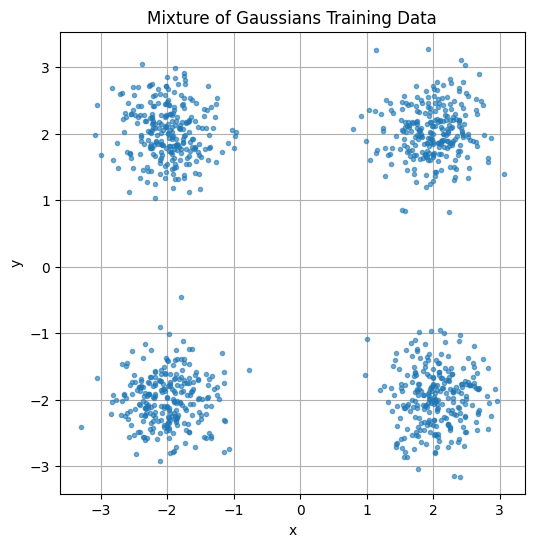

In [15]:
plt.figure(figsize=(6, 6))
plt.plot(train_data_gmm[:, 0], train_data_gmm[:, 1], '.', alpha=0.6)
plt.title("Mixture of Gaussians Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.show()


# Section 2 Create DataLoader for Mixture of Gaussians


In [16]:
batch_size = 32

train_loader_gmm = torch.utils.data.DataLoader(
    train_set_gmm,
    batch_size=batch_size,
    shuffle=True
)

print(f"Total number of batches (GMM): {len(train_loader_gmm)}")

Total number of batches (GMM): 32


# Section 2 Modified Discriminator Model (for GMM)


In [17]:
class DiscriminatorGMM(nn.Module):
    def __init__(self):
        super(DiscriminatorGMM, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator_gmm = DiscriminatorGMM().to(device)
print(discriminator_gmm)

DiscriminatorGMM(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


# Section 2 Modified Generator Model (for GMM)


In [18]:
class GeneratorGMM(nn.Module):
    def __init__(self):
        super(GeneratorGMM, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

generator_gmm = GeneratorGMM().to(device)
print(generator_gmm)

GeneratorGMM(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


# Section 2 – Optimizers for GMM GAN


In [20]:
optimizer_discriminator_gmm = torch.optim.Adam(discriminator_gmm.parameters(), lr=lr)
optimizer_generator_gmm = torch.optim.Adam(generator_gmm.parameters(), lr=lr)

print("GMM GAN optimizers ready.")

GMM GAN optimizers ready.


# Section 2 Train GAN on Mixture of Gaussians Data


In [21]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader_gmm):
        real_samples = real_samples.to(device)

        real_labels = torch.ones((batch_size, 1)).to(device)

        noise = torch.randn((batch_size, 2)).to(device)
        fake_samples = generator_gmm(noise)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        all_samples = torch.cat((real_samples, fake_samples), dim=0)
        all_labels = torch.cat((real_labels, fake_labels), dim=0)

        discriminator_gmm.zero_grad()
        output = discriminator_gmm(all_samples)
        loss_discriminator = loss_function(output, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator_gmm.step()

        noise = torch.randn((batch_size, 2)).to(device)
        generator_gmm.zero_grad()
        generated_samples = generator_gmm(noise)
        output_discriminator = discriminator_gmm(generated_samples)

        loss_generator = loss_function(output_discriminator, real_labels)
        loss_generator.backward()
        optimizer_generator_gmm.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss D: {loss_discriminator.item():.4f} | Loss G: {loss_generator.item():.4f}")


Epoch 0 | Loss D: 0.4164 | Loss G: 2.1827
Epoch 200 | Loss D: 0.6890 | Loss G: 0.6672
Epoch 400 | Loss D: 0.5765 | Loss G: 0.7855
Epoch 600 | Loss D: 0.5972 | Loss G: 0.7487
Epoch 800 | Loss D: 0.6859 | Loss G: 0.6527
Epoch 1000 | Loss D: 0.6849 | Loss G: 0.7466
Epoch 1200 | Loss D: 0.6907 | Loss G: 0.6687
Epoch 1400 | Loss D: 0.6846 | Loss G: 0.7027
Epoch 1600 | Loss D: 0.6934 | Loss G: 0.6647
Epoch 1800 | Loss D: 0.7095 | Loss G: 0.7500


# Section 2 Generate and Visualize GMM Samples


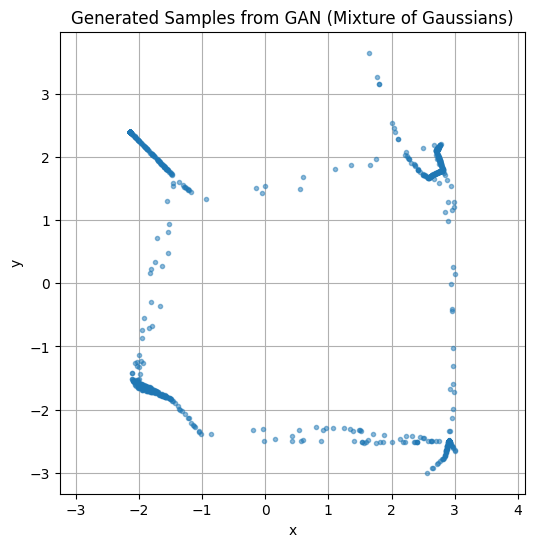

In [22]:
latent_samples_gmm = torch.randn(1000, 2).to(device)
generated_data_gmm = generator_gmm(latent_samples_gmm).detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.plot(generated_data_gmm[:, 0], generated_data_gmm[:, 1], ".", alpha=0.5)
plt.title("Generated Samples from GAN (Mixture of Gaussians)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.show()